In [21]:
import fastf1 as ff
import fastf1.plotting as plotting
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

ff.Cache.enable_cache('../cache')
plotting.setup_mpl()
colormap = mpl.cm.viridis

### 0. test plot

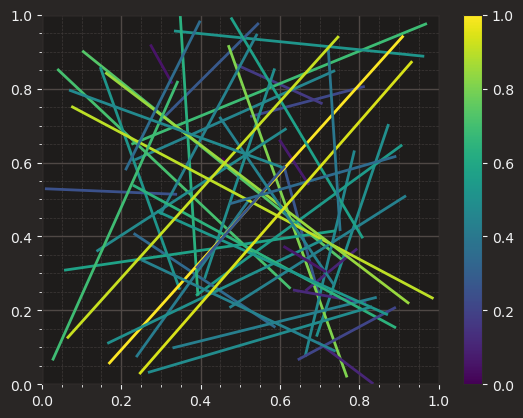

In [22]:
# 生成随机线段
n_lines = 50
points = np.random.rand(n_lines, 2, 2)

# 计算每条线段的长度
lengths = np.sqrt(np.sum(np.diff(points, axis=1)**2, axis=2))

# 创建一个颜色映射
norm = plt.Normalize(lengths.min(), lengths.max())
colors = plt.cm.viridis(norm(lengths))

# 创建LineCollection对象并绘制
lc = LineCollection(points, colors=colors, linewidths=2)
fig, ax = plt.subplots()
ax.add_collection(lc)
plt.colorbar(lc)

plt.show()

### 1. plot fastest lap

In [23]:
session1 = ff.get_session(2023, 1, 'Q')
session1.load()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/Users/blank/miniforge3/envs/python310/lib/python3.10/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
/Users/blank/miniforge3/envs/python310/lib/python3.10/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
/Users/blank/miniforge3/envs/python310/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, obje

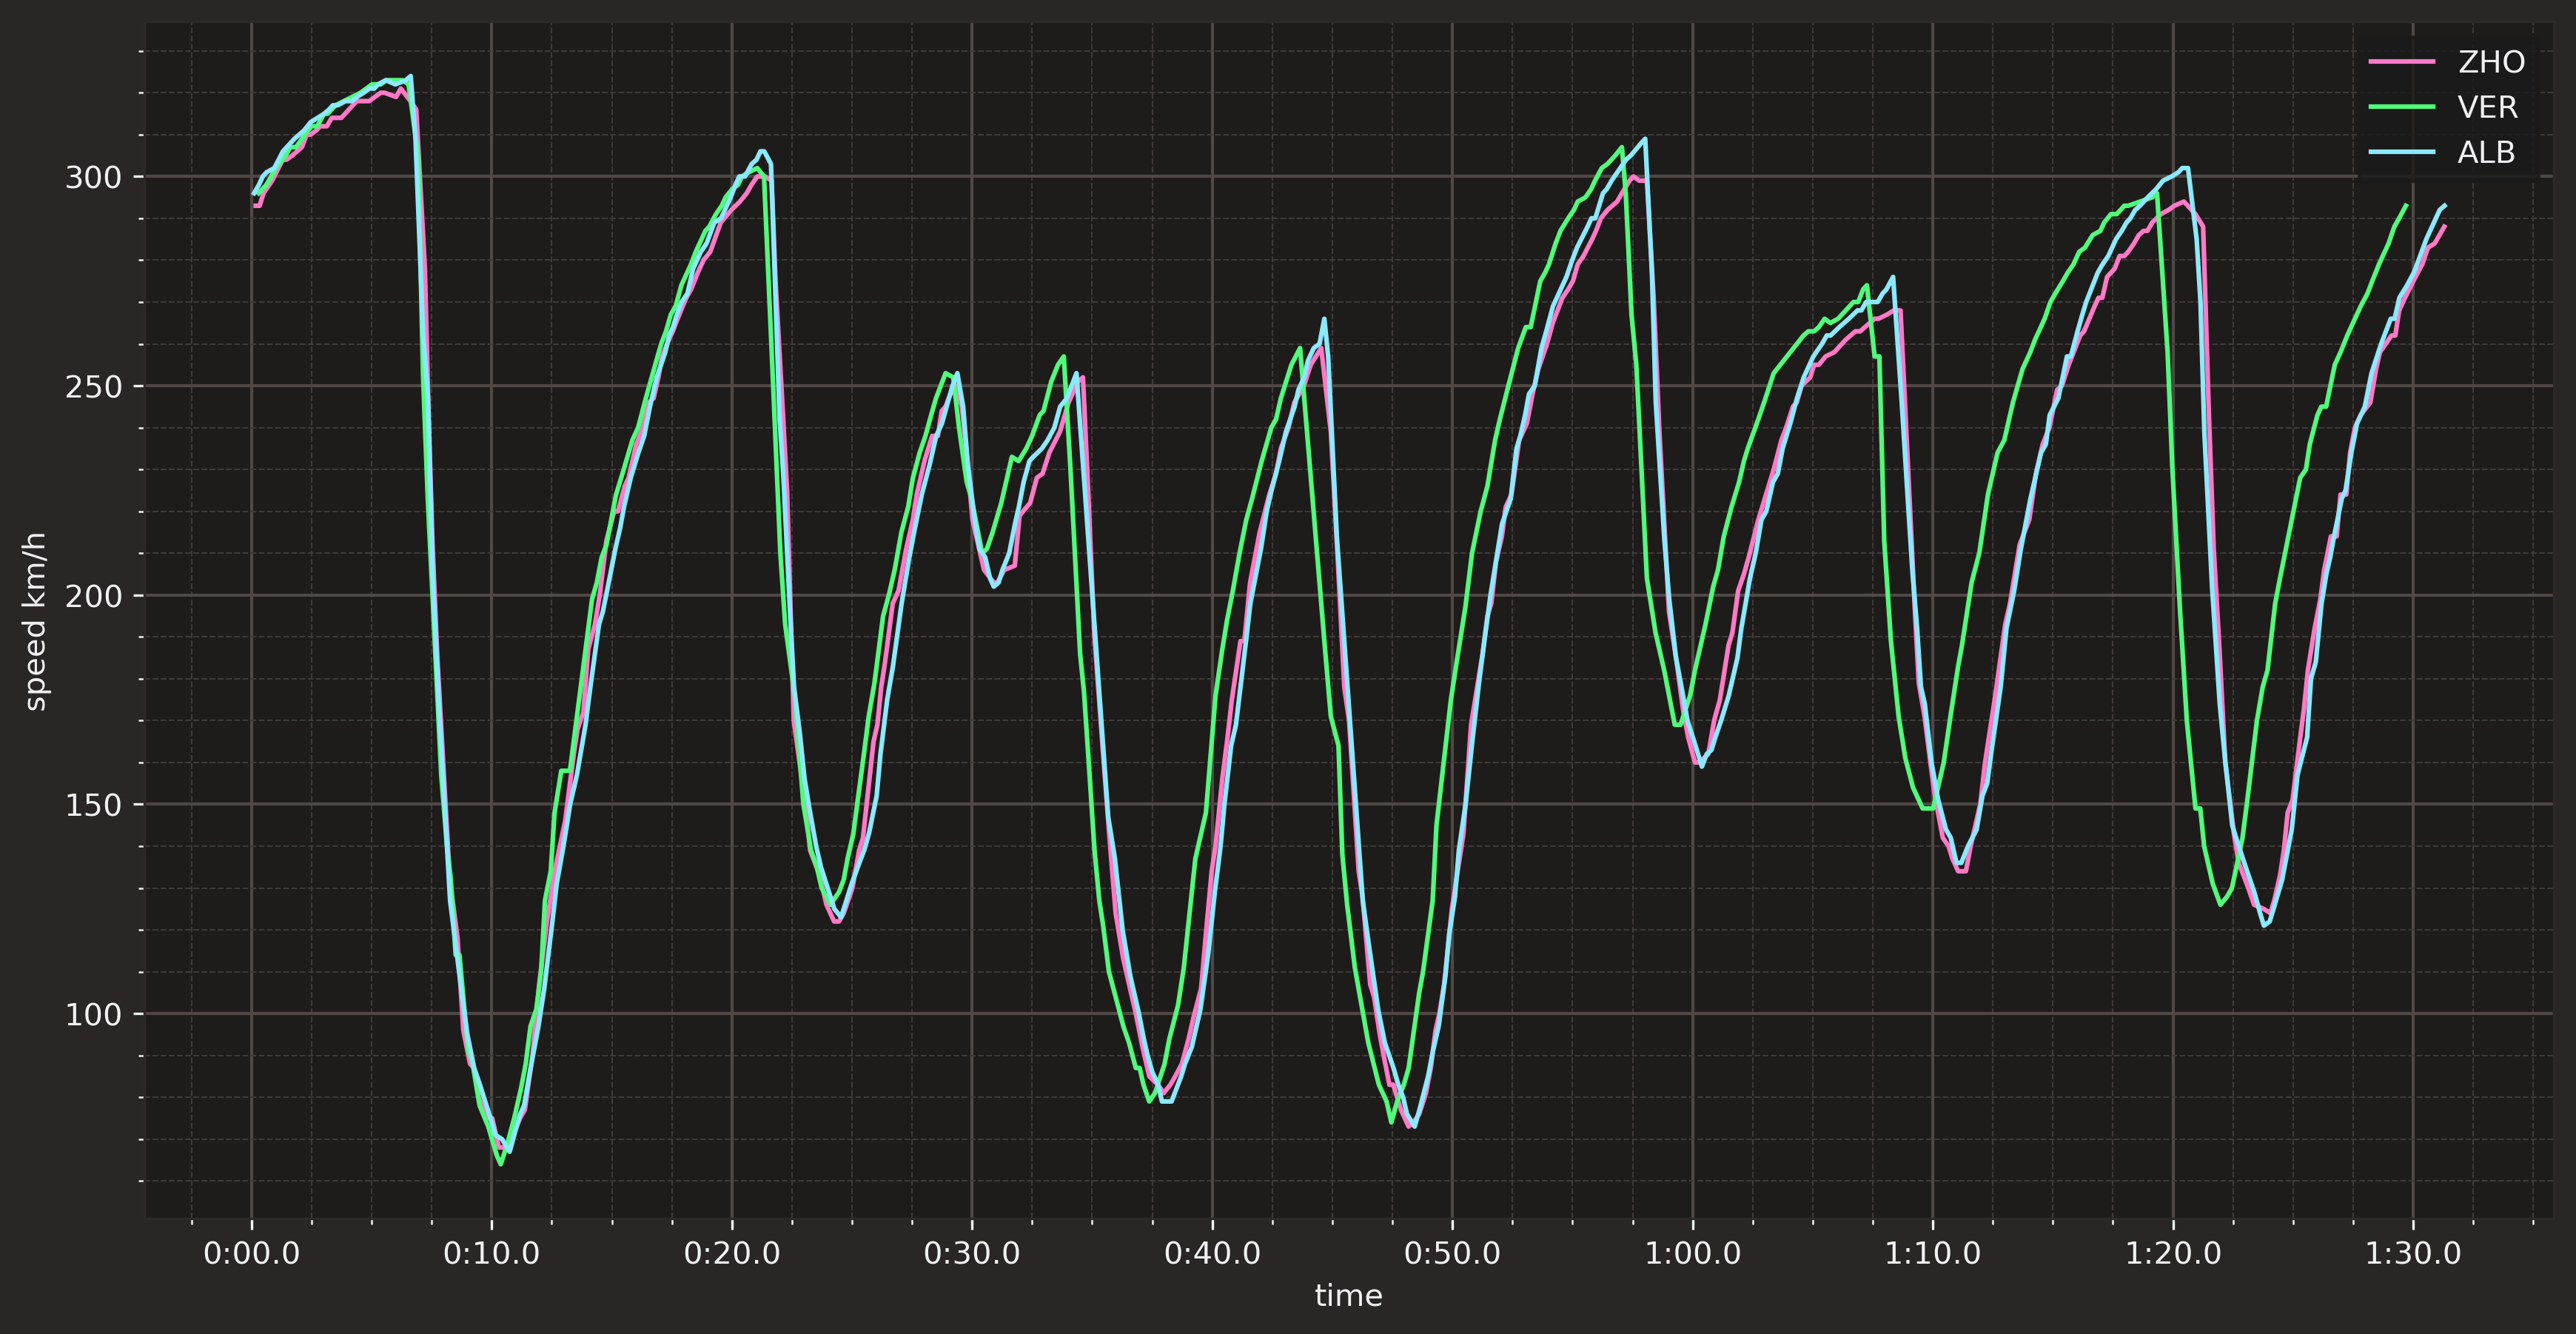

In [24]:
laps1 = session1.laps
zho_fastest = laps1.pick_driver('ZHO').pick_fastest().get_car_data()
ver_fastest = laps1.pick_driver('VER').pick_fastest().get_car_data()
alb_fastest = laps1.pick_driver('ALB').pick_fastest().get_car_data()

fig, ax = plt.subplots(figsize=(14, 7), dpi=300)
ax.plot(zho_fastest['Time'], zho_fastest['Speed'], label='ZHO')
ax.plot(ver_fastest['Time'], ver_fastest['Speed'], label='VER')
ax.plot(alb_fastest['Time'], alb_fastest['Speed'], label='ALB')
ax.set_xlabel('time')
ax.set_ylabel('speed km/h')
ax.legend()
plt.show()

### 2. plot single lap

In [25]:
session2 = ff.get_session(2022, 1, 'Q')
session2.load()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
/Users/blank/miniforge3/envs/python310/lib/python3.10/site-packages/fastf1/core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)
/Users/blank/miniforge3/envs/python310/lib/python3.10/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
/Users/blank/miniforge3/envs/python310/lib/python3

In [26]:
laps2 = session2.laps
zho_lap = laps2.pick_driver('ZHO').pick_fastest()

zho_x = zho_lap.telemetry['X']
zho_y = zho_lap.telemetry['Y']
zho_color = zho_lap.telemetry['Speed']
zho_gear = zho_lap.telemetry['nGear']

In [27]:
# 将x, y坐标结合并转置, 得到连续的点的坐标数组
# 提前准备数据到三维方便后续处理
# 714 * 1 * 2
zho_points = np.array([zho_x, zho_y]).T.reshape(-1, 1, 2)
print(zho_points)
print(zho_points.shape)
print('--------')

# 将连续的点之间两两连接, 得到连续的线段数组
# 713 * 2 * 2
zho_segments = np.concatenate([zho_points[:-1], zho_points[1:]], axis=1)
print(zho_segments)
print(zho_segments.shape)
print('--------')

# 添加 gear 信息
zho_gears = zho_gear.to_numpy().astype(float)

[[[-379 1280]]

 [[-379 1297]]

 [[-374 1395]]

 ...

 [[-390 1064]]

 [[-381 1264]]

 [[-376 1361]]]
(714, 1, 2)
--------
[[[-379 1280]
  [-379 1297]]

 [[-379 1297]
  [-374 1395]]

 [[-374 1395]
  [-372 1458]]

 ...

 [[-391 1061]
  [-390 1064]]

 [[-390 1064]
  [-381 1264]]

 [[-381 1264]
  [-376 1361]]]
(713, 2, 2)
--------


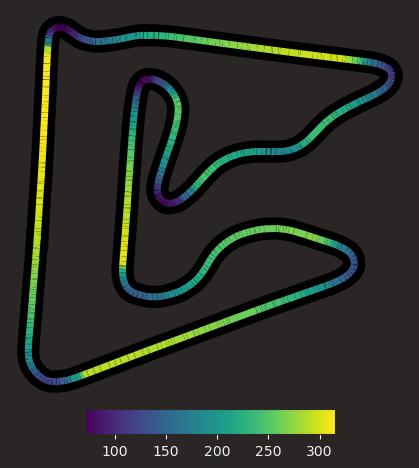

In [28]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(5, 5))

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# After this, we plot the data itself.
# Create background track line
ax.plot(zho_lap.telemetry['X'], zho_lap.telemetry['Y'], color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(zho_color.min(), zho_color.max())
lc = LineCollection(zho_segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

# Set the values used for color mapping
lc.set_array(zho_color)

# Merge all line segments together
line = ax.add_collection(lc)

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=zho_color.min(), vmax=zho_color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")

# Show the plot
plt.show()

[]

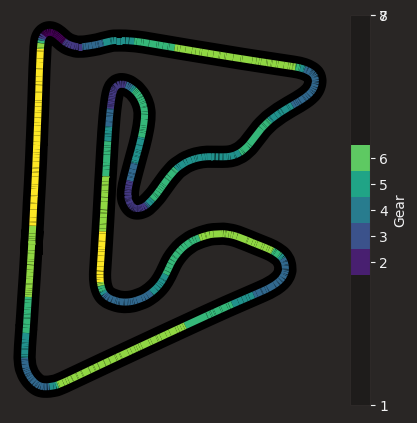

In [29]:
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(5, 5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')
ax.plot(zho_lap.telemetry['X'], zho_lap.telemetry['Y'], color='black', linestyle='-', linewidth=16, zorder=0)
norm = plt.Normalize(zho_gears.min(), zho_gears.max())
lc = LineCollection(zho_segments, cmap=colormap, norm=norm, linestyles='-', linewidth=5)
lc.set_array(zho_gears)
line = ax.add_collection(lc)
cbar = plt.colorbar(mappable=lc, label='Gear', boundaries=np.arange(zho_gears.min(), zho_gears.max()))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(np.arange(1, 9))
plt.plot()